In [1]:
!pip install findspark
!pip install pyspark
!apt-get install -qq openjdk-17-jdk-headless
from google.colab import drive

Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../openjdk-17-jre-headless_17.0.14+7-1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jre-headless:amd64 (17.0.14+7-1~22.04.1) ...
Selecting previously unselected package openjdk-17-jdk-headless:amd64.
Preparing to unpack .../openjdk-17-jdk-headless_17.0.14+7-1~22.04.1_amd64.deb ...
Unpacking openjdk-17-jdk-headless:amd64 (17.0.14+7-1~22.04.1) ...
Setting up openjdk-17-jre-headless:amd64 (17.0.14+7-1~22.04.1) ...
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/jpackage to provide /usr/bin/jpackage (jpackage) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-17-openj

In [3]:
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [4]:
import findspark, os
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("IG Calculation") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

In [5]:
train = spark.read.parquet('/content/drive/MyDrive/exports/dataset/train_without_ig.parquet')
test = spark.read.parquet("/content/drive/MyDrive/exports/dataset/test_without_ig.parquet")
full  = train.unionByName(test)

print(f"full: {full.count():,} lines, {len(full.columns)} columns")
full.printSchema()

full: 412,497 lines, 51 columns
root
 |-- Police_Force_ind: double (nullable = true)
 |-- Accident_Severity_ind: double (nullable = true)
 |-- Number_of_Vehicles_ind: double (nullable = true)
 |-- Number_of_Casualties_ind: double (nullable = true)
 |-- Local_Authority_(District)_ind: double (nullable = true)
 |-- 1st_Road_Class_ind: double (nullable = true)
 |-- Road_Type_ind: double (nullable = true)
 |-- Speed_limit_ind: double (nullable = true)
 |-- Junction_Detail_ind: double (nullable = true)
 |-- Junction_Control_ind: double (nullable = true)
 |-- Pedestrian_Crossing-Human_Control_ind: double (nullable = true)
 |-- Pedestrian_Crossing-Physical_Facilities_ind: double (nullable = true)
 |-- Light_Conditions_ind: double (nullable = true)
 |-- Weather_Conditions_ind: double (nullable = true)
 |-- Road_Surface_Conditions_ind: double (nullable = true)
 |-- Special_Conditions_at_Site_ind: double (nullable = true)
 |-- Carriageway_Hazards_ind: double (nullable = true)
 |-- Urban_or_Rural

In [6]:
import pyspark.sql.functions as F
import math
from pyspark.ml.feature import VectorAssembler, StandardScaler, QuantileDiscretizer
from pyspark.ml.clustering import KMeans
import pandas as pd
import matplotlib.pyplot as plt, numpy as np
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import PCA
from scipy.stats import chi2
import matplotlib.patches as mpatches
from pyspark.ml.functions import vector_to_array

In [7]:
#we count how many distinct values does every column has and display only top 20
row = (full
       .agg(*[F.countDistinct(c).alias(c) for c in full.columns])
       .first())
card_dict = row.asDict()

card_df = (spark.createDataFrame([(k, v) for k, v in card_dict.items()],
                                 ["attribute", "n_unique"])
                 .orderBy(F.desc("n_unique")))
card_df.show(20, truncate=False)

+------------------------------------+--------+
|attribute                           |n_unique|
+------------------------------------+--------+
|Local_Authority_(District)_ind      |416     |
|Casualty_Reference_ind              |78      |
|Vehicle_Reference_ind               |67      |
|Vehicle_Reference_Casualty_ind      |65      |
|Police_Force_ind                    |51      |
|Casualty_Type_ind                   |21      |
|Vehicle_Type_ind                    |20      |
|Vehicle_Manoeuvre_ind               |18      |
|Hit_Object_in_Carriageway_ind       |12      |
|Hit_Object_off_Carriageway_ind      |12      |
|Propulsion_Code_ind                 |11      |
|Pedestrian_Location_ind             |11      |
|Vehicle_Location-Restricted_Lane_ind|10      |
|Pedestrian_Movement_ind             |10      |
|Junction_Detail_ind                 |9       |
|Vehicle_Leaving_Carriageway_ind     |9       |
|Weather_Conditions_ind              |9       |
|Junction_Location_ind               |9 

In [8]:
# we dropped atributes with >25 unique values, bc there are indexes
kept_cols = [c for c, n in card_dict.items() if n <= 25]

filtered = full.select(*kept_cols)
print(f"we left {len(kept_cols)} columns out of {len(full.columns)}")

we left 46 columns out of 51


In [9]:
# check unique value for every column to be sure we dont need to discritize something
numeric_cols = [c for c, t in filtered.dtypes
                if t in ("double", "int", "float", "bigint")]

for c in numeric_cols:
    n_u = filtered.select(F.countDistinct(c)).first()[0]
    print(f"{c:30}  distinct = {n_u}")

Accident_Severity_ind           distinct = 3
Number_of_Vehicles_ind          distinct = 3
Number_of_Casualties_ind        distinct = 3
1st_Road_Class_ind              distinct = 6
Road_Type_ind                   distinct = 6
Speed_limit_ind                 distinct = 3
Junction_Detail_ind             distinct = 9
Junction_Control_ind            distinct = 6
Pedestrian_Crossing-Human_Control_ind  distinct = 3
Pedestrian_Crossing-Physical_Facilities_ind  distinct = 6
Light_Conditions_ind            distinct = 5
Weather_Conditions_ind          distinct = 9
Road_Surface_Conditions_ind     distinct = 5
Special_Conditions_at_Site_ind  distinct = 8
Carriageway_Hazards_ind         distinct = 6
Urban_or_Rural_Area_ind         distinct = 3
Did_Police_Officer_Attend_Scene_of_Accident_ind  distinct = 3
Vehicle_Type_ind                distinct = 20
Towing_and_Articulation_ind     distinct = 6
Vehicle_Manoeuvre_ind           distinct = 18
Vehicle_Location-Restricted_Lane_ind  distinct = 10
Junction_

In [10]:
# we calculate entropy for each attribute
N = filtered.count()

def entropy(col):
    """H(X) = -Σ p log2 p  where  p = count / N"""
    freq = (filtered.groupBy(col).count()
                       .withColumn("p", F.col("count") / N))
    return float(freq.select(F.sum(-F.col("p") * F.log2("p"))).first()[0])

entropies = [(c, entropy(c)) for c in filtered.columns]
E_single = {c: entropy(c) for c in filtered.columns}


entropy_df = (spark.createDataFrame(entropies, ["attribute", "entropy"])
                     .orderBy("entropy"))
entropy_df.show(20, truncate=False)

+-----------------------------------------------+--------------------+
|attribute                                      |entropy             |
+-----------------------------------------------+--------------------+
|Was_Vehicle_Left_Hand_Drive?_ind               |0.042402271745250214|
|Pedestrian_Crossing-Human_Control_ind          |0.0498666372842059  |
|Towing_and_Articulation_ind                    |0.1440300481212149  |
|Bus_or_Coach_Passenger_ind                     |0.16969075287822954 |
|Carriageway_Hazards_ind                        |0.16979580246127973 |
|Vehicle_Location-Restricted_Lane_ind           |0.18887662235382513 |
|Special_Conditions_at_Site_ind                 |0.24010720078775985 |
|Hit_Object_in_Carriageway_ind                  |0.33144973757726603 |
|Pedestrian_Location_ind                        |0.5260510341436492  |
|Pedestrian_Movement_ind                        |0.5345701383802055  |
|Casualty_Severity_ind                          |0.5496047249402892  |
|Did_P

In [11]:
# greedy cycle, each time we remove attribute whose removal gives the maximum reduction of the total entropy.
SERVICE  = {"Accident_Severity_ind"}
current  = {c for c in filtered.columns if c not in SERVICE}

EPS       = 0.01         # absolute threshold ∆E
REL_EPS   = 0.01         # 1% оf initial ΣE
N_MIN     = 5

initial_E = sum(E_single[c] for c in current)
total_E   = initial_E
history   = []

while len(current) > N_MIN:
    candidates = [(c, E_single[c]) for c in current]
    if not candidates:
        break

    best_col, best_drop = max(candidates, key=lambda x: x[1])

    rel_drop = best_drop / initial_E
    if best_drop < EPS or rel_drop < REL_EPS:
        break

    current.remove(best_col)
    total_E -= best_drop
    history.append((best_col, best_drop, total_E))

best_attrs = list(current)
print(f"Greedy is done: {len(best_attrs)} attributes left "
      f"out of {len(filtered.columns)}\n")
print("list:", best_attrs)

print("logs (attr, ∆E, ΣE after removal):")
for col, drop, newE in history:
    print(f"{col:<35} -{drop:.4f}  → {newE:.4f}")

final = filtered.select(*best_attrs)

Greedy is done: 8 attributes left out of 46

list: ['Special_Conditions_at_Site_ind', 'Carriageway_Hazards_ind', 'Vehicle_Location-Restricted_Lane_ind', 'Hit_Object_in_Carriageway_ind', 'Was_Vehicle_Left_Hand_Drive?_ind', 'Towing_and_Articulation_ind', 'Pedestrian_Crossing-Human_Control_ind', 'Bus_or_Coach_Passenger_ind']
logs (attr, ∆E, ΣE after removal):
Vehicle_Manoeuvre_ind               -2.8789  → 47.4266
Junction_Location_ind               -2.2756  → 45.1510
Junction_Detail_ind                 -2.2661  → 42.8849
1st_Road_Class_ind                  -1.9502  → 40.9347
1st_Point_of_Impact_ind             -1.9445  → 38.9902
Casualty_Type_ind                   -1.9373  → 37.0528
Journey_Purpose_of_Driver_ind       -1.9105  → 35.1423
Age_of_Casualty_ind                 -1.7078  → 33.4344
Junction_Control_ind                -1.6392  → 31.7952
Vehicle_Type_ind                    -1.5547  → 30.2405
Propulsion_Code_ind                 -1.5217  → 28.7188
Driver_Home_Area_Type_ind           

k =  2  |  WSSE = 2,932,887.80
k =  3  |  WSSE = 2,549,839.99
k =  4  |  WSSE = 2,279,022.18
k =  5  |  WSSE = 2,189,920.07
k =  6  |  WSSE = 1,887,407.76
k =  7  |  WSSE = 1,848,434.62
k =  8  |  WSSE = 1,279,228.18
k =  9  |  WSSE = 1,268,334.88
k = 10  |  WSSE = 1,227,047.89
k = 11  |  WSSE = 972,359.80
k = 12  |  WSSE = 594,631.18
k = 13  |  WSSE = 479,256.38
k = 14  |  WSSE = 705,779.30
k = 15  |  WSSE = 417,404.40


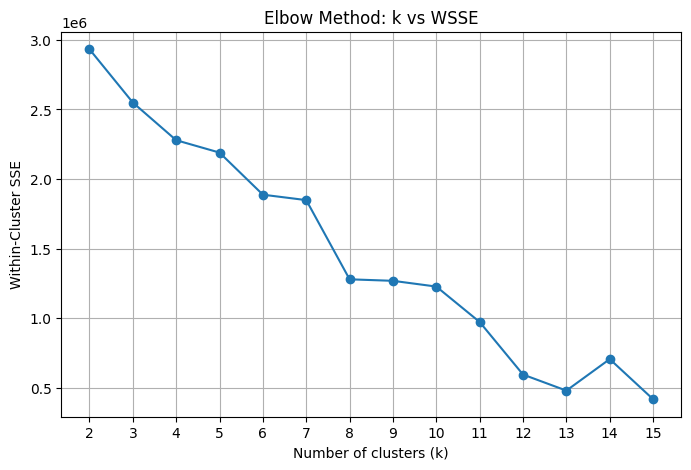

In [12]:
# we use VectorAssembler and StandardScaler to features
assembler = VectorAssembler(inputCols=best_attrs, outputCol="vec")
vec_df    = assembler.transform(final)

scaler_m  = StandardScaler(withMean=True, withStd=True,
                           inputCol="vec", outputCol="features") \
            .fit(vec_df)
data = scaler_m.transform(vec_df).select("features").cache()

# we search WSSE at k = 2 ... 15
results = []
for k in range(2, 16):
    km      = KMeans(k=k, seed=1234, featuresCol="features")
    model   = km.fit(data)
    wsse    = model.summary.trainingCost
    results.append((k, wsse))
    print(f"k = {k:2d}  |  WSSE = {wsse:,.2f}")

k_vals, wsse_vals = zip(*results)
wsse_arr = np.array(wsse_vals)

plt.figure(figsize=(8,5))
plt.plot(k_vals, wsse_vals, marker='o')
plt.title('Elbow Method: k vs WSSE')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster SSE')
plt.grid(True)
plt.xticks(k_vals)
plt.show()

In [13]:
# we chose k = 5 and train k-means
kmeans_final = KMeans(k=5, seed=1234, featuresCol="features")
model_final  = kmeans_final.fit(data)

In [14]:
# we use local Mahalanobis distance to find outliners
clustered = model_final.transform(data)
d = clustered.first()["features"].size

# for each cluster we calclate mean vecor (µ_r) and inverse covariance (Σ_r⁻¹)
def seq_op(acc, vec):
    n, s, ss = acc
    arr = vec.toArray()
    return (n+1,
            s  + arr,
            ss + np.outer(arr, arr))

def comb_op(a, b):
    n1,s1,ss1 = a
    n2,s2,ss2 = b
    return (n1+n2, s1+s2, ss1+ss2)

zero = (0, np.zeros(d), np.zeros((d,d)))

stats = (clustered
         .select("prediction", "features")
         .rdd
         .aggregateByKey(zero, seq_op, comb_op)
         .mapValues(lambda t: (
             t[1] / t[0],                               # µ_r
             np.linalg.pinv(t[2]/t[0] -                 # Σ_r⁻¹
                            np.outer(t[1]/t[0], t[1]/t[0]))
         ))
         .collectAsMap())

bc_stats = spark.sparkContext.broadcast(stats)

# local Mahalanobis distance
def maha(vec, cid):
    mu, inv = bc_stats.value[int(cid)]
    dvec    = vec.toArray() - mu
    return float(np.sqrt(dvec.dot(inv).dot(dvec)))

maha_udf = F.udf(maha, DoubleType())

scored = (clustered
          .withColumn("mahalanobis", maha_udf("features","prediction"))
          .cache())


# local thresholds and outliners
chi_thr = float(np.sqrt(chi2.ppf(0.99, df=d)))

outliers = scored.filter(F.col("mahalanobis") >= chi_thr)

print(f"χ²-threshold (α=0.99, df={d}) = {chi_thr:.3f}")
print(f"Outliers found : {outliers.count()}  /  {scored.count()}")

# outliners pre each cluster
(outliers.groupBy("prediction")
         .agg(F.count("*").alias("n_outliers"))
         .orderBy("prediction")
         .show())

χ²-threshold (α=0.99, df=8) = 4.482
Outliers found : 21634  /  412497
+----------+----------+
|prediction|n_outliers|
+----------+----------+
|         0|     20608|
|         1|       597|
|         2|        86|
|         3|       130|
|         4|       213|
+----------+----------+



<ipython-input-15-70e5f9f92ac0>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", k)


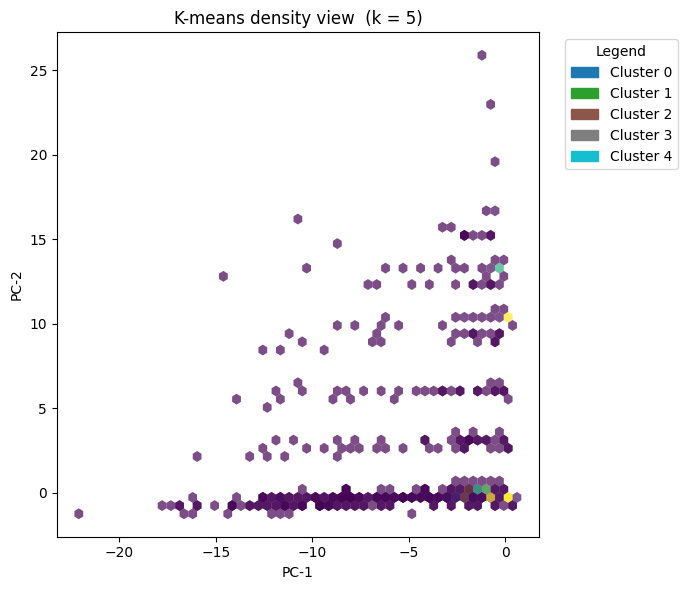

In [15]:
# we build hexagonal heat map using PCA
clustered = model_final.transform(data)
k = model_final.getK()

# 2d projection using PCA
if "pca2" not in clustered.columns:
    pca = PCA(k=2, inputCol="features", outputCol="pca2")
    clustered2d = pca.fit(clustered).transform(clustered)
else:
    clustered2d = clustered

pdf = (clustered2d
       .select("pca2", "prediction")
       .toPandas())

pdf["x"] = pdf["pca2"].apply(lambda v: float(v[0]))
pdf["y"] = pdf["pca2"].apply(lambda v: float(v[1]))

# hexbin map
palette = plt.cm.get_cmap("tab10", k)

plt.figure(figsize=(7,6))
handles = []
for cid in range(k):
    sub = pdf[pdf["prediction"] == cid]
    col = palette(cid)
    plt.hexbin(sub["x"], sub["y"],
               gridsize=50, mincnt=1,
               extent=[pdf["x"].min(), pdf["x"].max(),
                       pdf["y"].min(), pdf["y"].max()],
               color=col, alpha=0.7, linewidths=0)
    handles.append(mpatches.Patch(color=col, label=f"Cluster {cid}"))

plt.title(f"K-means density view  (k = {k})")
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.legend(handles=handles, title="Legend",
           bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout(); plt.show()

<ipython-input-16-c4068d3f1fdc>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10", k)


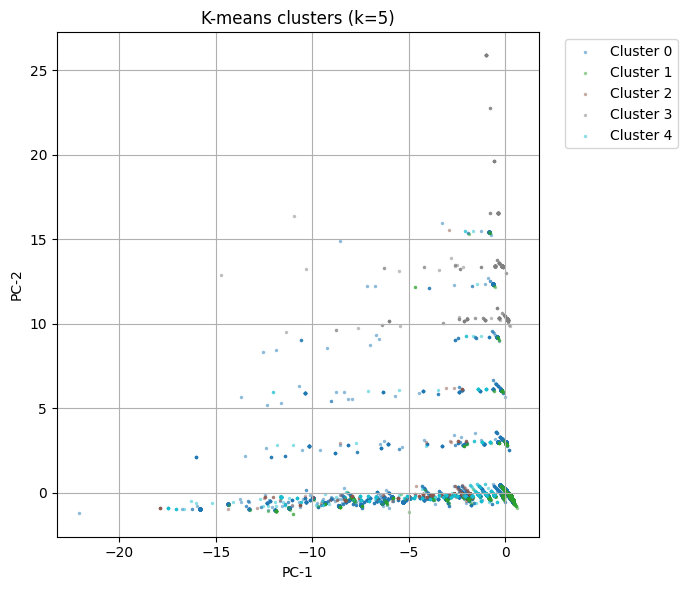

In [16]:
# we build cluster scatter-plot using PCA
plt.figure(figsize=(7,6))
palette = plt.cm.get_cmap("tab10", k)

for cid in range(k):
    sub = pdf[pdf["prediction"] == cid]
    plt.scatter(sub["x"], sub["y"],
                s=6, alpha=0.5,
                color=palette(cid),
                label=f"Cluster {cid}", linewidths=0)

plt.title(f"K-means clusters (k={k})")
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid(True); plt.tight_layout()
plt.show()